<div style="float:left">
    <h1 style="width:450px">Practical 8: Dimensions in Data</h1>
    <h2 style="width:450px">Transformation &amp; Dimensionality Reduction</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

In this session the focus is on MSOA-level Census data from 2011. We're going to explore this as a *possible* complement to the InsideAirbnb data. Although it's not ideal to use 2011 data with scraped Airbnb data from 2022 data, we: 

1. Have little choice as the 2021 data is only just starting to come through from the Census; and 
2. Could usefully do a bit of thinking about whether the situation in 2011 might in some way help us to 'predict' the situation now...

Ultimately, however, you don't *need* to use this for your analysis, this practical is intended as a demonstration of how transformation and dimensionality reduction work in practice and the kinds of issues that come up.

## Preamble

Let's start with the usual bits of code to ensure plotting works, to import packages and load the data into memory.

In [2]:
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

import umap
from kneed import knee_locator

In [3]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## Task 1. Loading MSOA Census Data

<div class="alert alert-block alert-success">
    <b>&#128161; Tip:</b> We're going to mix in the London's MSOA 'Atlas' from the <a href="https://data.london.gov.uk/dataset">London Data Store</a>. I would <em>strongly</em> suggest that you have a look around the Data Store as you develop your thinking for the group assessment -- you will likely find useful additional data there!
</div>

Once you see how we deal with this MSOA Atlas data you will be in a position to look at the socio-economic **context** of Airbnb listings at the MSOA level, or with any other similar data set. If you're feeling particularly ambitious you can actually do this _same_ work at the LSOA scale using the [LSOA Atlas](https://data.london.gov.uk/dataset/lsoa-atlas) and LSOA boundaries... the process should be the same, though you will have smaller samples in each LSOA than you do in the MSOAs and calculations will take a bit longer to complete.

There is a CSV file for the MSOA Atlas that would be easier to work with; however, the Excel file is useful for demonstrating how to work with multi-level indexes (an extension of last week's work). Notice that below we do two new things when reading the XLS file:

1. We have to specify a sheet name because the file contains multiple sheets.
2. We have to specify a header _and_ we actually have to specify three of them which generates a multi-level index (row 0 is the top-level, row 1 is the second-level, etc.).

### Task 1.1: Load MSOA Excel File

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

You might like to load a copy of the Excel file into Excel so that you can see how the next bit works. You can find the MSOA Atlas [here](https://data.london.gov.uk/dataset/msoa-atlas).

In [3]:
src_url   = 'https://data.london.gov.uk/download/msoa-atlas/39fdd8eb-e977-4d32-85a4-f65b92f29dcb/msoa-data.xls'
dest_path = os.path.join('data','msoa')

excel_atlas = pd.read_excel(
    cache_data(src_url, dest_path), 
    sheet_name='iadatasheet1', # Which sheet is the data in?
    header=[0,1,2])            # Where are the column names... there's three of them!

Found data/msoa/msoa-data.xls locally!


Notice the format of the output and notice that all of the empty cells in the Excel sheet have come through as `Unnamed: <col_no>_level_<level_no>`:

In [4]:
excel_atlas.head(1)

Unnamed: 0_level_0  Unnamed: 1_level_0 Age Structure (2011 Census)  \
  Unnamed: 0_level_1  Unnamed: 1_level_1                    All Ages   
           MSOA Code           MSOA Name          Unnamed: 2_level_2   
0          E02000001  City of London 001                      7375.0   

                                                                               \
                0-15              16-29              30-44              45-64   
  Unnamed: 3_level_2 Unnamed: 4_level_2 Unnamed: 5_level_2 Unnamed: 6_level_2   
0              620.0             1665.0             2045.0             2010.0   

                                        Mid-year Estimate totals  ...  \
                 65+        Working-age                 All Ages  ...   
  Unnamed: 7_level_2 Unnamed: 8_level_2                     2002  ...   
0             1035.0             5720.0                   7280.0  ...   

  Road Casualties                                                           \
             2010             2011                            2012           
           Slight 2010 Total Fatal Serious Slight 2011 Total Fatal Serious   
0           334.0      374.0   0.0    46.0  359.0      405.0   2.0    51.0   

                     
                     
  Slight 2012 Total  
0  361.0      414.0  

[1 rows x 207 columns]

In [5]:
print(f"Shape of the MSOA Atlas data frame is: {excel_atlas.shape[0]:,} x {excel_atlas.shape[1]:,}")

Shape of the MSOA Atlas data frame is: 984 x 207


You should get: `Shape of the MSOA Atlas data frame is: 984 x 207`, but how on earth are you going to access the data?

### Task 1.2: Accessing MultiIndexes

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate, though the difficulty is conceptual, not technical.
</div>

Until now we have understood the pandas index as a single column-like 'thing' in a data frame, but pandas also supports hierarchical and grouped indexes that allow us to interact with data in more complex ways... should we need it. Generally:

- MultiIndex == hierarchical index on *columns*
- DataFrameGroupBy == iterable pseudo-hierarchical index on *rows*

#### 1.2.1 Direct Access

Of course, one way to get at the data is to use `.iloc[...]` since that refers to columns by *position* and ignores the complexity of the index. Try printing out the the first five rows of the first column using `iloc`:

In [6]:
excel_atlas.iloc[0:5,0]

0    E02000001
1    E02000002
2    E02000003
3    E02000004
4    E02000005
Name: (Unnamed: 0_level_0, Unnamed: 0_level_1, MSOA Code), dtype: object

You should get:

```
0    E02000001
1    E02000002
2    E02000003
3    E02000004
4    E02000005
Name: (Unnamed: 0_level_0, Unnamed: 0_level_1, MSOA Code), dtype: object
```

#### 1.2.2 Named Access

But to do it by name is a little trickier:

In [7]:
excel_atlas.columns.tolist()[:5]

[('Unnamed: 0_level_0', 'Unnamed: 0_level_1', 'MSOA Code'),
 ('Unnamed: 1_level_0', 'Unnamed: 1_level_1', 'MSOA Name'),
 ('Age Structure (2011 Census)', 'All Ages', 'Unnamed: 2_level_2'),
 ('Age Structure (2011 Census)', '0-15', 'Unnamed: 3_level_2'),
 ('Age Structure (2011 Census)', '16-29', 'Unnamed: 4_level_2')]

Notice how asking for the first five columns has given us a list of... what exactly?

So to get the same column by *name*:

In [8]:
excel_atlas.loc[0:5, ('Unnamed: 0_level_0','Unnamed: 0_level_1','MSOA Code')]

0    E02000001
1    E02000002
2    E02000003
3    E02000004
4    E02000005
5    E02000007
Name: (Unnamed: 0_level_0, Unnamed: 0_level_1, MSOA Code), dtype: object

#### 1.2.3 Grouped Access

*One* way that MultiIndexes can be useful is for accessing column-slices from a wide dataframe. We can, for instance, select all of the Age Structure columns in one go and it will be *simpler* than what we did above.

In [9]:
excel_atlas.loc[0:5, ('Age Structure (2011 Census)')]

,All Ages,0-15,16-29,30-44,45-64,65+,Working-age
,Unnamed: 2_level_2,Unnamed: 3_level_2,Unnamed: 4_level_2,Unnamed: 5_level_2,Unnamed: 6_level_2,Unnamed: 7_level_2,Unnamed: 8_level_2
0,7375.0,620.0,1665.0,2045.0,2010.0,1035.0,5720.0
1,6775.0,1751.0,1277.0,1388.0,1258.0,1101.0,3923.0
2,10045.0,2247.0,1959.0,2300.0,2259.0,1280.0,6518.0
3,6182.0,1196.0,1277.0,1154.0,1543.0,1012.0,3974.0
4,8562.0,2200.0,1592.0,1995.0,1829.0,946.0,5416.0
5,8791.0,2388.0,1765.0,1867.0,1736.0,1035.0,5368.0


#### 1.2.4 Understanding Levels

This works because the MultiIndex tracks the columns using *levels*, with level 0 at the 'top' and level 2 (in our case) at the bottom. These are the unique *levels*:

In [10]:
excel_atlas.columns.levels[0]

Index(['Adults in Employment (2011 Census)', 'Age Structure (2011 Census)',
       'Car or van availability (2011 Census)',
       'Central Heating (2011 Census)', 'Country of Birth (2011)',
       'Dwelling type (2011)', 'Economic Activity (2011 Census)',
       'Ethnic Group (2011 Census)', 'Health (2011 Census)', 'House Prices',
       'Household Composition (2011)', 'Household Income Estimates (2011/12)',
       'Household Language (2011)', 'Households (2011)', 'Incidence of Cancer',
       'Income Deprivation (2010)', 'Land Area', 'Life Expectancy',
       'Lone Parents (2011 Census)', 'Low Birth Weight Births (2007-2011)',
       'Mid-year Estimate totals', 'Mid-year Estimates 2012, by age',
       'Obesity', 'Population Density', 'Qualifications (2011 Census)',
       'Religion (2011)', 'Road Casualties', 'Tenure (2011)',
       'Unnamed: 0_level_0', 'Unnamed: 1_level_0'],
      dtype='object')

These are the *values* for those levels across the actual columns in the data frame, notice the repeated 'Age Structure (2011 Census)':

In [11]:
excel_atlas.columns.get_level_values(0)[:10]

Index(['Unnamed: 0_level_0', 'Unnamed: 1_level_0',
       'Age Structure (2011 Census)', 'Age Structure (2011 Census)',
       'Age Structure (2011 Census)', 'Age Structure (2011 Census)',
       'Age Structure (2011 Census)', 'Age Structure (2011 Census)',
       'Age Structure (2011 Census)', 'Mid-year Estimate totals'],
      dtype='object')

In [12]:
excel_atlas.columns.get_level_values(1)[:10]

Index(['Unnamed: 0_level_1', 'Unnamed: 1_level_1', 'All Ages', '0-15', '16-29',
       '30-44', '45-64', '65+', 'Working-age', 'All Ages'],
      dtype='object')

By extension, if we drop a level 0 index then *all* of the columns that it supports at levels 1 and 2 are _also_ dropped: so when we drop `Mid-year Estimate totals` from level 0 then all 11 of the 'Mid-year Estimate totals (2002...2012)' columns are dropped in one go.

In [13]:
excel_atlas[['Mid-year Estimate totals']].head(3)

Mid-year Estimate totals                                                  \
                  All Ages                                                   
                      2002    2003    2004    2005    2006    2007    2008   
0                   7280.0  7115.0  7118.0  7131.0  7254.0  7607.0  7429.0   
1                   6333.0  6312.0  6329.0  6341.0  6330.0  6323.0  6369.0   
2                   9236.0  9252.0  9155.0  9072.0  9144.0  9227.0  9564.0   

                                      
                                      
     2009     2010     2011     2012  
0  7472.0   7338.0   7412.0   7604.0  
1  6570.0   6636.0   6783.0   6853.0  
2  9914.0  10042.0  10088.0  10218.0

In [14]:
test = excel_atlas.drop(columns=['Mid-year Estimate totals'], axis=1, level=0)

In [15]:
print(f"Excel source had {excel_atlas.shape[1]} columns.")
print(f"Test now has {test.shape[1]} columns.")

Excel source had 207 columns.
Test now has 196 columns.


#### 1.2.5 Questions

- What data type is used for storing/accessing MultiIndexes? 

> It's a tuple, in this case a triplet.

- *Why* is this is the appropriate data type?

> Because you don't want a mutable data type like a list for a data source: tuples are immutable so you can't accidentally overwrite/change them without explicitly writing back to the index.

- How (conceptually) are the header rows in Excel are mapped on to levels in pandas?

> Each header row becomes a level in the MultiIndex: in some cases this is what we expect/want (e.g. the mid-year estimates selection), but it can also return a lot of 'Unnamed' values that can be hard to work with directly.

### Task 1.3: Tidying Up

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low, though there's a lot of dealing with column names.
</div>

#### 1.3.1 Dropping Named Levels

There's a *lot* of data in the data frame that we don't need for our Airbnb work, so let's go a bit further with the dropping of column-groups using the MultiIndex.

In [16]:
to_drop = ['Mid-year Estimate totals','Mid-year Estimates 2012, by age','Religion (2011)',
           'Land Area','Lone Parents (2011 Census)','Central Heating (2011 Census)','Health (2011 Census)',
           'Low Birth Weight Births (2007-2011)','Obesity','Incidence of Cancer','Life Expectancy',
           'Road Casualties']
tidy = excel_atlas.drop(to_drop, axis=1, level=0)
print(f"Shape of the MSOA Atlas data frame is now: {tidy.shape[0]} x {tidy.shape[1]}")

Shape of the MSOA Atlas data frame is now: 984 x 111


This should drop you down to `984 x 111`. Notice below that the multi-level _index_ has not changed but the multi-level _values_ remaining have!

In [17]:
print(tidy.columns.levels[0]) # The categories
print(tidy.columns.get_level_values(0)) # The actual values

Index(['Adults in Employment (2011 Census)', 'Age Structure (2011 Census)',
       'Car or van availability (2011 Census)',
       'Central Heating (2011 Census)', 'Country of Birth (2011)',
       'Dwelling type (2011)', 'Economic Activity (2011 Census)',
       'Ethnic Group (2011 Census)', 'Health (2011 Census)', 'House Prices',
       'Household Composition (2011)', 'Household Income Estimates (2011/12)',
       'Household Language (2011)', 'Households (2011)', 'Incidence of Cancer',
       'Income Deprivation (2010)', 'Land Area', 'Life Expectancy',
       'Lone Parents (2011 Census)', 'Low Birth Weight Births (2007-2011)',
       'Mid-year Estimate totals', 'Mid-year Estimates 2012, by age',
       'Obesity', 'Population Density', 'Qualifications (2011 Census)',
       'Religion (2011)', 'Road Casualties', 'Tenure (2011)',
       'Unnamed: 0_level_0', 'Unnamed: 1_level_0'],
      dtype='object')
Index(['Unnamed: 0_level_0', 'Unnamed: 1_level_0',
       'Age Structure (2011 Census

#### 1.3.2 Selecting Columns using a List Comprehension

Now we need to drop all of the percentages from the data set. These can be found at level 1, though they are specified in a number of different ways so you'll need to come up with a way to find them in the level 1 values using a list comprehension... 

I'd suggest looking for: "(%)", "%", and "Percentages". You may need to check both start and end. You could also use a regular expression here instead multiple tests:

In [18]:
to_drop = [x for x in tidy.columns.get_level_values(1) if (
    x.endswith("(%)") or x.startswith("%") or x.endswith("Percentages") or x.endswith("%"))]
print(to_drop)

['Percentages', 'Percentages', 'Percentages', 'Percentages', 'Percentages', 'White (%)', 'Mixed/multiple ethnic groups (%)', 'Asian/Asian British (%)', 'Black/African/Caribbean/Black British (%)', 'Other ethnic group (%)', 'BAME (%)', 'United Kingdom (%)', 'Not United Kingdom (%)', '% of people aged 16 and over in household have English as a main language', '% of households where no people in household have English as a main language', 'Owned: Owned outright (%)', 'Owned: Owned with a mortgage or loan (%)', 'Social rented (%)', 'Private rented (%)', 'Household spaces with at least one usual resident (%)', 'Household spaces with no usual residents (%)', 'Whole house or bungalow: Detached (%)', 'Whole house or bungalow: Semi-detached (%)', 'Whole house or bungalow: Terraced (including end-terrace) (%)', 'Flat, maisonette or apartment (%)', 'Economically active %', 'Economically inactive %', '% of households with no adults in employment: With dependent children', '% living in income depri

In [19]:
print([x for x in tidy.columns.get_level_values(1) if re.search("(?:%|Percentages)", x)])

['Percentages', 'Percentages', 'Percentages', 'Percentages', 'Percentages', 'White (%)', 'Mixed/multiple ethnic groups (%)', 'Asian/Asian British (%)', 'Black/African/Caribbean/Black British (%)', 'Other ethnic group (%)', 'BAME (%)', 'United Kingdom (%)', 'Not United Kingdom (%)', '% of people aged 16 and over in household have English as a main language', '% of households where no people in household have English as a main language', 'Owned: Owned outright (%)', 'Owned: Owned with a mortgage or loan (%)', 'Social rented (%)', 'Private rented (%)', 'Household spaces with at least one usual resident (%)', 'Household spaces with no usual residents (%)', 'Whole house or bungalow: Detached (%)', 'Whole house or bungalow: Semi-detached (%)', 'Whole house or bungalow: Terraced (including end-terrace) (%)', 'Flat, maisonette or apartment (%)', 'Economically active %', 'Economically inactive %', '% of households with no adults in employment: With dependent children', '% living in income depri

You should get:
```
['Percentages', 'Percentages', 'Percentages', 'Percentages', 'Percentages', 'White (%)', 'Mixed/multiple ethnic groups (%)', 'Asian/Asian British (%)', 'Black/African/Caribbean/Black British (%)', 'Other ethnic group (%)', 'BAME (%)', 'United Kingdom (%)', 'Not United Kingdom (%)', '% of people aged 16 and over in household have English as a main language', '% of households where no people in household have English as a main language', 'Owned: Owned outright (%)', 'Owned: Owned with a mortgage or loan (%)', 'Social rented (%)', 'Private rented (%)', 'Household spaces with at least one usual resident (%)', 'Household spaces with no usual residents (%)', 'Whole house or bungalow: Detached (%)', 'Whole house or bungalow: Semi-detached (%)', 'Whole house or bungalow: Terraced (including end-terrace) (%)', 'Flat, maisonette or apartment (%)', 'Economically active %', 'Economically inactive %', '% of households with no adults in employment: With dependent children', '% living in income deprived households reliant on means tested benefit', '% of people aged over 60 who live in pension credit households', 'No cars or vans in household (%)', '1 car or van in household (%)', '2 cars or vans in household (%)', '3 cars or vans in household (%)', '4 or more cars or vans in household (%)']
```

#### 1.3.3 Drop by Level

You now need to drop these columns using the `level` keyword as part of your drop command. You have plenty of examples of how to drop values in place, but I'd suggest _first_ getting the command correct and allowing to it return a new data frame and _then_ adding the in place parameter.

In [20]:
tidy.drop(to_drop, axis=1, level=1, inplace=True)
print(f"Shape of the MSOA Atlas data frame is now: {tidy.shape[0]} x {tidy.shape[1]}")

Shape of the MSOA Atlas data frame is now: 984 x 76


The data frame is now `984 x 76`. This is a _bit_ more manageable though still a _lot_ of data columns. Depending on what you decide to do for your final project you might want to revisit some of the columns that we dropped above... 

#### 1.3.4 Flattening the Index

Although this ia big improvement, you'll have trouble saving or linking this data to other inputs. The problem is that Level 2 of the multi-index is mainly composed of 'Unnamed' values and so we need to merge it with Level 1 to simplify our data frame, and then merge _that_ with level 0...

In [21]:
tidy.columns.values[:3]

array([('Unnamed: 0_level_0', 'Unnamed: 0_level_1', 'MSOA Code'),
       ('Unnamed: 1_level_0', 'Unnamed: 1_level_1', 'MSOA Name'),
       ('Age Structure (2011 Census)', 'All Ages', 'Unnamed: 2_level_2')],
      dtype=object)

Let's use code to sort this out!

In [22]:
new_cols = []
for c in tidy.columns.values:
    
    #print(f"Column label: {c}")
    l1 = f"{c[0]}"
    l2 = f"{c[1]}"
    l3 = f"{c[2]}"
    
    # The new column label
    clabel = ''
    
    # Assemble new label from the levels
    if not l1.startswith("Unnamed"):
        l1 = l1.replace(" (2011 Census)",'').replace(" (2011)",'').replace("Household ",'').replace("House Prices",'').replace("Car or van availability",'Vehicles').replace(' (2011/12)','')
        l1 = l1.replace('Age Structure','Age').replace("Ethnic Group",'').replace('Dwelling type','').replace('Income Estimates','')
        clabel += l1
    if not l2.startswith("Unnamed"):
        l2 = l2.replace("Numbers",'').replace(" House Price (£)",'').replace("Highest level of qualification: ",'').replace("Annual Household Income (£)",'hh Income').replace('Whole house or bungalow: ','').replace(' qualifications','')
        l2 = l2.replace('At least one person aged 16 and over in household has English as a main language',"1+ English as a main language").replace("No people in household have English as a main language","None have English as main language")
        clabel += ('-' if clabel != '' else '') + l2
    if not l3.startswith("Unnamed"):
        clabel += ('-' if clabel != '' else '') + l3
    
    # Replace other commonly-occuring verbiage that inflates column name width
    clabel = clabel.replace('--','-').replace(" household",' hh').replace('Owned: ','')
    
    #clabel = clabel.replace(' (2011 Census)','').replace(' (2011)','').replace('Sales - 2011.1','Sales - 2012')
    #clabel = clabel.replace('Numbers - ','').replace(' (£)','').replace('Car or van availability','Vehicles')
    #clabel = clabel.replace('Household Income Estimates (2011/12) - ','').replace('Age Structure','Age')
    
    new_cols.append(clabel)

print(new_cols)

['MSOA Code', 'MSOA Name', 'Age-All Ages', 'Age-0-15', 'Age-16-29', 'Age-30-44', 'Age-45-64', 'Age-65+', 'Age-Working-age', 'Households-All Households', 'Composition-Couple hh with dependent children', 'Composition-Couple hh without dependent children', 'Composition-Lone parent hh', 'Composition-One person hh', 'Composition-Other hh Types', 'White', 'Mixed/multiple ethnic groups', 'Asian/Asian British', 'Black/African/Caribbean/Black British', 'Other ethnic group', 'BAME', 'Country of Birth-United Kingdom', 'Country of Birth-Not United Kingdom', 'Language-1+ English as a main language', 'Language-None have English as main language', 'Tenure-Owned outright', 'Tenure-Owned with a mortgage or loan', 'Tenure-Social rented', 'Tenure-Private rented', 'Household spaces with at least one usual resident', 'Household spaces with no usual residents', 'Detached', 'Semi-detached', 'Terraced (including end-terrace)', 'Flat, maisonette or apartment', 'Population Density-Persons per hectare (2012)', '

In [23]:
tidy.columns = new_cols
tidy.head()

,MSOA Code,MSOA Name,Age-All Ages,Age-0-15,Age-16-29,Age-30-44,Age-45-64,Age-65+,Age-Working-age,Households-All Households,...,Adults in Employment-No adults in employment in hh: With dependent children,Total Mean hh Income,Total Median hh Income,Vehicles-No cars or vans in hh,Vehicles-1 car or van in hh,Vehicles-2 cars or vans in hh,Vehicles-3 cars or vans in hh,Vehicles-4 or more cars or vans in hh,Vehicles-Sum of all cars or vans in the area,Vehicles-Cars per hh
0,E02000001,City of London 001,7375.0,620.0,1665.0,2045.0,2010.0,1035.0,5720.0,4385.0,...,38.0,59728.481886,46788.295472,3043.0,1100.0,173.0,51.0,18.0,1692.0,0.385861
1,E02000002,Barking and Dagenham 001,6775.0,1751.0,1277.0,1388.0,1258.0,1101.0,3923.0,2713.0,...,319.0,31788.185996,27058.703760,1020.0,1186.0,424.0,66.0,17.0,2305.0,0.849613
2,E02000003,Barking and Dagenham 002,10045.0,2247.0,1959.0,2300.0,2259.0,1280.0,6518.0,3834.0,...,268.0,43356.931547,36834.528738,1196.0,1753.0,691.0,155.0,39.0,3766.0,0.982264
3,E02000004,Barking and Dagenham 003,6182.0,1196.0,1277.0,1154.0,1543.0,1012.0,3974.0,2318.0,...,122.0,46701.436554,39668.206433,556.0,1085.0,515.0,128.0,34.0,2650.0,1.143227
4,E02000005,Barking and Dagenham 004,8562.0,2200.0,1592.0,1995.0,1829.0,946.0,5416.0,3183.0,...,307.0,34293.820288,29155.683536,1080.0,1423.0,551.0,109.0,20.0,2937.0,0.922714


In [24]:
# You might want to have a look at _what_ this drops first
tidy.drop(index=tidy[tidy['MSOA Code'].isna()].index, inplace=True)

### Task 1.4: Add Inner/Outer London Mapping

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate, since I'm not giving you many clues.
</div>

Now try to add the borough name and a regional mapping using a **lambda** function to populate a new column called `Subregion` using the `Borough` column as a source. The format for a lambda function is usually `lambda x: <code that does something with x and returns a value>`. Hint: you've got a dictionary and you know how to use it!

#### 1.4.1 Add Boroughs

We first need to extract the borough names from one of the existing fields in the data frame... a *regex* that does *replacement* would be fastest and easiest: focus on what you *don't* need from the MSOA Name and replacing that away...

In [25]:
tidy['Borough'] = tidy['MSOA Name'].str.replace(' \d+$','',regex=True)
tidy.Borough.unique()

array(['City of London', 'Barking and Dagenham', 'Barnet', 'Bexley',
       'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
       'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Newham', 'Redbridge',
       'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Westminster'], dtype=object)

#### 1.4.2 Map Boroughs to Subregions

In [26]:
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden','City of London']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet']:
    mapping[b]='Outer West and North West'

tidy['Subregion'] = tidy.Borough.apply(lambda x: mapping[x])

#### 1.4.3 And Save

In [27]:
tidy.to_feather(os.path.join('data','clean','MSOA_Atlas.feather'))
print("Done.")

Done.


#### 1.4.4 Questions

- What are the advantages to `apply` and `lambda` functions over looping and named functions? 

> With `apply` we don't have to worry about iteration and writing loops, we just ask pandas to 'sort it out' for us and don't care how it achieves this. The leaves pandas free to use mutiple threads or cores. Using `lambda` functions is also a quick and easy way to declare and use one-off functions: we'll only use this mapping once, so writing and naming a function to do this simply isn't necessary.

- When might you choose a named function over a lambda function?

> Partly if you're going to be reusing the function multiple times, but mostly when the function parameters and processing steps become too complex to fit on one line or might entail default values or other options.

### Task 1.5: Merge Data & Geography

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low, except for plotting.
</div>

First, we need to download the MSOA source file, which is a zipped archive of a Shapefile:

In [28]:
msoas = gpd.read_file(
    cache_data('https://github.com/jreades/fsds/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true', 
               os.path.join('data','geo','London_MSOAs.shp.zip')), driver='ESRI Shapefile')

data/geo/London_MSOAs.shp.zip/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip not found, downloading!
Done downloading...


#### 1.5.1 Identifying Matching Columns

In [29]:
tidy.columns.tolist()[:5]

['MSOA Code', 'MSOA Name', 'Age-All Ages', 'Age-0-15', 'Age-16-29']

In [30]:
msoas.columns.tolist()[:5]

['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'MSOA11NMW', 'BNG_E']

#### 1.5.2 Merge

In [31]:
gdf = pd.merge(msoas, tidy, left_on='MSOA11CD', right_on='MSOA Code', how='inner')
gdf = gdf.drop(columns=['MSOA11CD','MSOA11NM','OBJECTID'])

print(f"Final MSOA Atlas data frame has shape {gdf.shape[0]:,} x {gdf.shape[1]}")

Final MSOA Atlas data frame has shape 983 x 86


You should get `Final data frame has shape 983 x 86`.

#### 1.5.3 Plot Choropleth

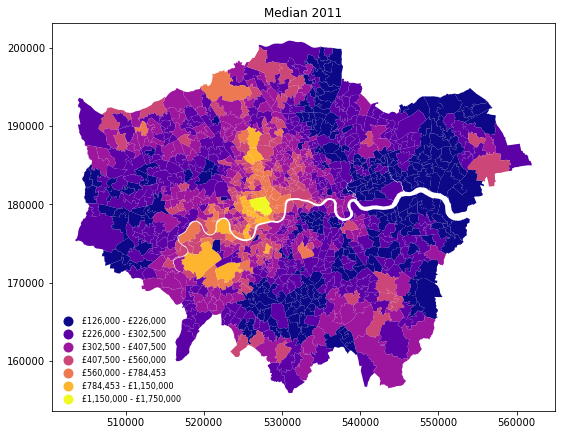

In [32]:
col = 'Median-2011'
fig = gdf.plot(column=col, cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', 
         legend=True, legend_kwds={'frameon':False, 'fontsize':8},
         figsize=(9,8));
plt.title(col.replace('-',' '));

# Now to modify the legend: googling "geopandas format legend"
# brings me to: https://stackoverflow.com/a/56591102/4041902
leg = fig.get_legend()
leg._loc = 3

for lbl in leg.get_texts():
    label_text = lbl.get_text()
    [low, hi] = label_text.split(', ')
    new_text = f'£{float(low):,.0f} - £{float(hi):,.0f}'
    lbl.set_text(new_text)

plt.show();

#### 1.5.4 Save

In [33]:
%%time
gdf.to_file(os.path.join('data','geo','MSOA_Atlas.gpkg'), driver='GPKG')
print("Done.")

Done.
CPU times: user 2.69 s, sys: 206 ms, total: 2.89 s
Wall time: 3.64 s


In [34]:
%%time
gdf.to_feather(os.path.join('data','geo','MSOA_Atlas.geofeather'))
print("Done.")

Done.
CPU times: user 73.5 ms, sys: 34.7 ms, total: 108 ms
Wall time: 145 ms


#### 1.5.5 Questions

- Try changing the colour scheme, classification scheme, and number of classes to see if you feel there's a *better* opeion than the one shown above...

> No right answer to this, but I can think of good reasons for using other schemes for something like income: quantiles would be good so that you can get at the 'bottom 10% of MSOAs' or use a divergent colour scale centred on the mid-point (50th quantile) so that you can get at how far an area falls from the median. For instance.

## Task 2. Splitting into Test & Train

A standard approach to Machine Learning, and something that is becoming more widely used elsewhere, is the splitting of a large data into set into testing and training components. Typically, you would take 80-90% of your data to 'train' your algorithm and withold between 10-20% for validation ('testing'). An even 'stricter' approach, in the sense of trying to ensure the robustness of your model against outlier effects, is [cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) such as [k-folds cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html). Here we are just going to use it to explore the issues raised in normalisation and standardisation by the use of SciKit-Learn's pipeline architecture with streaming data.

So Sci-Kit Learn is often used in a model-validation context in which we are trying to _predict_ something. So Sci-Kit Learn _expects_ that you'll have an `X` which is your **predictors** (the inputs to your model) and a `y` which is the thing you're **trying to predict**. We're obviously not building a model here (that's for Term 2!) so we'll just 'pretend' that we're trying to predict the price of a listing and will set that up as our `y` data set. Notice too that you can pass a data frame directly to Sci-Kit Learn and it will split it for you.

### Task 2.1: Reload

<div class="alert alert-block alert-success">
    <b>&#128161; Tip</b>: In future 'runs' of this notebook you can now just pick up here and skip all of Task 1.
</div>

On subsequent runs of this notebook you might just want to start here!

In [35]:
gdf = gpd.read_feather(os.path.join('data','geo','MSOA_Atlas.geofeather'))
print(gdf.shape)

(983, 86)


In [36]:
categoricals = ['Borough','Subregion']
for c in categoricals:
    gdf[c] = gdf[c].astype('category')

### Task 2.2: Split

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low!
</div>

For our purposes this is a little bit overkill as you could also use pandas' `sample(frac=0.2)` and the indexes, but it's useful to see how this works. Ordinarily, you would use this when building a model where you have both predictors _and_ a target. These would be held separately and then you use test/train split to ensure that you get four data sets out the training (predictors + target as separate data sets) and the training (predictors + target as separate data sets) accoridng to the `test_size` specfied in the `test_train_split` parameters.

In [37]:
from sklearn.model_selection import train_test_split 

pdf = gdf['Median-2011'].copy() # pdf for Median *P*rice b/c we need *something*

# df == *data* frame (a.k.a. predictors or independent variables)
# pr == *predicted* value (a.k.a. dependent variable)
df_train, df_test, pr_train, pr_test = train_test_split(gdf, pdf, test_size=0.2, random_state=44)

Below you should see that the data has been split roughly on the basis of the `test_size` parameter.

In [38]:
print(f"Original data size: {gdf.shape[0]:,} x {gdf.shape[1]}")
print(f"  Training data size: {df_train.shape[0]:,} x {df_train.shape[1]} ({(df_train.shape[0]/gdf.shape[0])*100:.0f}%)")
print(f"  Testing data size:  {df_test.shape[0]:,} x {df_test.shape[1]} ({(df_test.shape[0]/gdf.shape[0])*100:.0f}%)")

Original data size: 983 x 86
  Training data size: 786 x 86 (80%)
  Testing data size:  197 x 86 (20%)


Also notice the indexes of the testing data sets:

In [39]:
print(", ".join([str(x) for x in df_train.index[:10]]))
print(", ".join([str(x) for x in pr_train.index[:10]]))

810, 502, 471, 74, 415, 316, 15, 37, 877, 449
810, 502, 471, 74, 415, 316, 15, 37, 877, 449


### Task 2.3: Plot Test/Train Data

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low, but important!
</div>

In [6]:
boros = gpd.read_file(os.path.join('data','geo','Boroughs.gpkg'))

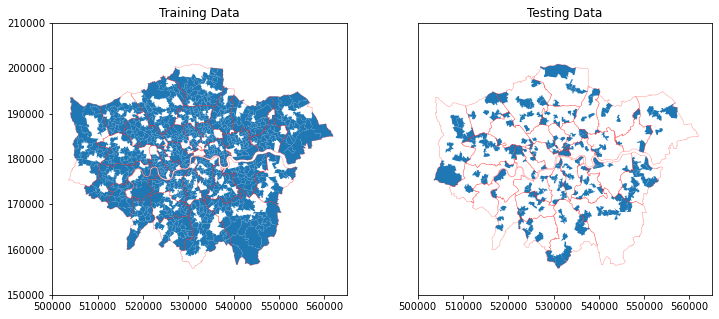

In [41]:
f,axes = plt.subplots(1,2, figsize=(12,5))
df_train.plot(ax=axes[0])
df_test.plot(ax=axes[1])
boros.plot(ax=axes[0], facecolor='none', edgecolor='r', linewidth=.5, alpha=0.4)
boros.plot(ax=axes[1], facecolor='none', edgecolor='r', linewidth=.5, alpha=0.4)
axes[0].set_title('Training Data')
axes[1].set_title('Testing Data');
axes[0].set_ylim(150000,210000)
axes[1].set_ylim(150000,210000)
axes[0].set_xlim(500000,565000)
axes[1].set_xlim(500000,565000)
axes[1].set_yticks([]);

#### 2.3.1 Questions

- Why might it be useful to produce a *map* of a test/train split? 

> Because we might want to think about whether the sample fulfills the *CSR* criteria: this is a crude eyeball only, but there is no obvious bias in our sample.

- Why might it matter *more* if you were dealing with user locations or behaviours?

> In the above case MSOAs are already controlled for size (i.e. they contain a fairly consistent number of individuals and households) so normal random-sampling isn't an issue, but if we split only on the basis of *row* without taking *geography* (or makeup of the data) into account for something like Tweets or tap-ins then we might end up over-sampling in some areas and under-sampling in others.

## Task 3. Normalisation

The developers of [SciKit-Learn](https://scikit-learn.org/) define [normalisation](https://scikit-learn.org/stable/modules/preprocessing.html#normalization) as "scaling individual samples to have **unit norm**." There are a _lot_ of subtleties to this when you start dealing with 'sparse' data, but for the most part it's worthwhile to think of this as a rescaling of the raw data to have similar ranges in order achieve some kind of comparison. This is such a common problem that sklearn offers a range of such (re)scalers including: `MinMaxScaler`.

Let's see what effect this has on the data!

In [42]:
# Sets some handy 'keywords' to tweak the Seaborn plot
kwds = dict(s=7,alpha=0.95,edgecolor="none")

# Set the *hue order* so that all plots have the *same*
# colour on the Subregion
ho = ['Inner East','Inner West','Outer West and North West','Outer South','Outer East and North East']

### Task 3.1: Select Columns

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

One thing you'll need to explain is why I keep writing `df[cols+['Subregion']` and why I don't just add it to the `cols` variable at the start?

In [43]:
cols = ['Tenure-Owned outright', 'Tenure-Owned with a mortgage or loan',
        'Tenure-Social rented', 'Tenure-Private rented']

In [44]:
tr_raw  = df_train[cols+['Subregion']].copy() # train raw
tst_raw = df_test[cols+['Subregion']].copy()  # test raw

### Task 3.2: Fit to Data

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate if you want to understand what <tt>reshape</tt> is doing.
</div>

In [45]:
from sklearn.preprocessing import MinMaxScaler

# Notice what this is doing! See if you can explain it clearly.
scalers = [MinMaxScaler().fit(df_train[x].values.reshape(-1,1)) for x in cols]

### Task 3.3: Apply Transformations

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

Train:

In [46]:
tr_normed = tr_raw.copy()

for i, sc in enumerate(scalers):
    # Ditto this -- can you explain what this code is doing
    tr_normed[cols[i]] = sc.transform(df_train[cols[i]].values.reshape(-1,1))

Test:

In [47]:
tst_normed = tst_raw.copy()

for i, sc in enumerate(scalers):
    tst_normed[cols[i]] = sc.transform(df_test[cols[i]].values.reshape(-1,1))

Investigate the properties of `tst_normed` using the skills developed. You should be able to spot something unexpected using little more than the min and/or max for the transformed *test* column

In [49]:
# Investigate the properties of tst_normed using the skills developed

for c in cols:
    print(f"{c}:")
    print(f"  Minimum: {tst_normed[c].min():.4f}")
    print(f"  Maximum: {tst_normed[c].max():.4f}")

Tenure-Owned outright:
  Minimum: 0.0156
  Maximum: 0.7898
Tenure-Owned with a mortgage or loan:
  Minimum: -0.0178
  Maximum: 0.9164
Tenure-Social rented:
  Minimum: 0.0019
  Maximum: 0.9143
Tenure-Private rented:
  Minimum: 0.0141
  Maximum: 1.0000


### Task 3.4: Plot Distributions

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

In [50]:
tr_raw.columns     = [re.sub('(-|/)',"\n",x) for x in tr_raw.columns.values]
tst_raw.columns    = [re.sub('(-|/)',"\n",x) for x in tst_raw.columns.values]
tr_normed.columns  = [re.sub('(-|/)',"\n",x) for x in tr_normed.columns.values]
tst_normed.columns = [re.sub('(-|/)',"\n",x) for x in tst_normed.columns.values]

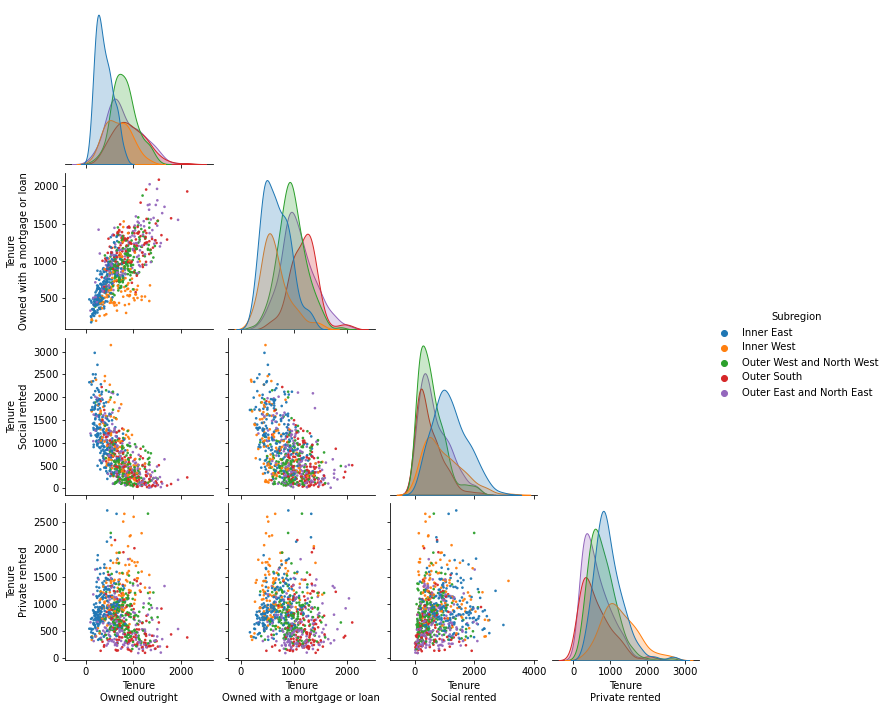

In [51]:
sns.pairplot(data=tr_raw, hue='Subregion', diag_kind='kde', corner=True, plot_kws=kwds, hue_order=ho);

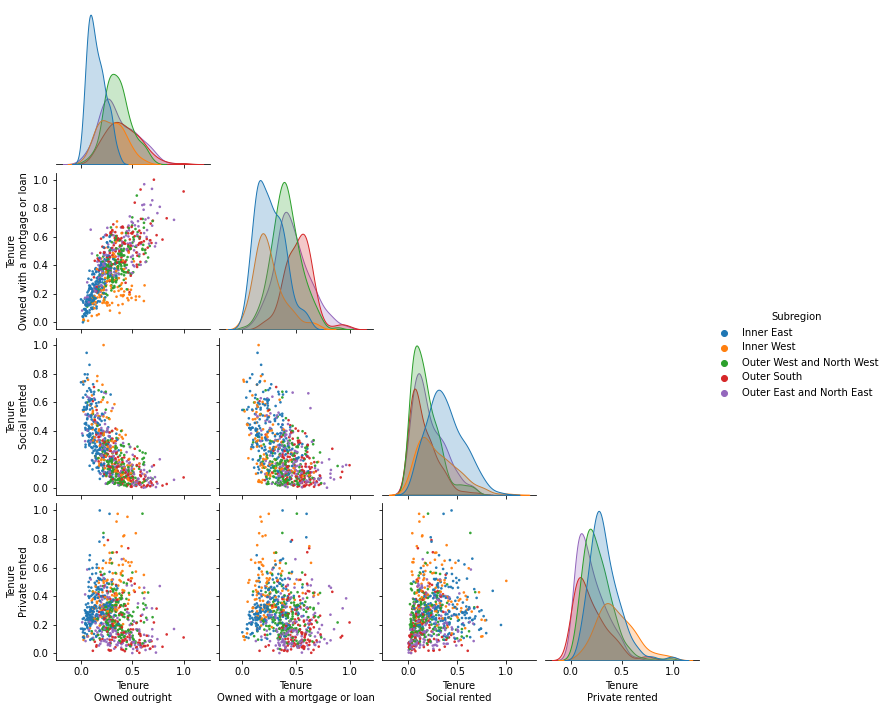

In [52]:
sns.pairplot(data=tr_normed, hue='Subregion', diag_kind='kde', corner=True, plot_kws=kwds, hue_order=ho);

#### 3.4.1 Questions

- Why do I keep writing `df[cols+['Subregion']`? Why I don't just add Subregions to the `cols` variable at the start?

> Because then it would be included in our transformation code! It's easier, for me at least, to add in the Subregions where I need them than to have to constantly remember to skip the last element in the `cols` array!

- What has changed between the two plots (of `tr_raw` and `tr_normed`)?

> In one sense, **nothing**! All we have done is tranformed the data so that the minimum is now 0 and the maximum 1 (for the most part), but notice that this hasn't had any impact on the observable *relationships* between data!

- What is the _potential_ problem that the use of the transformer fitted on `tr_normed` to data from `tst_normed` might cause? *Hint*: this is why I asked you to investigate the data in the empty code cell above.

> The normlised testing data _can_ have values that are *outside* the range 0..1. So this might cause issues where you _expect_ your MinMaxScaler to *always* produce results in the range 0..1.

- Can you explain what this is doing: `[MinMaxScaler().fit(df_train[x].values.reshape(-1,1)) for x in cols]`?

> We're creating a list of transformers that are trained on the specified columns from `cols`. However, for the input to be useable by Sci-Kit Learn we need to *reshape* the numpy array: this basically rotates a Numpy array into an $n \times 1` matrix (i.e. one column).

- Can you explain what *this* is doing: `sc.transform(df_test[cols[i]].values.reshape(-1,1))`?

> Here we apply the trained transformers to the test data: since `i` and `sc` are coming an enumeration we know that the scaler `sc` will line up with the `cols[i]` on which the scaler was trained (though in this case from the test data set).

## Task 4. Standardisation 

Standardisation is typically focussed on rescaling data to have a mean (or median) of 0 and standard deviation or IQR of 1. That these approaches are conceptually tied to the idea of symmetric, unimodal data such as that encountered in the standard normal distribution. Rather confusingly, many data scientists will use standardisation and normalisation largely interchangeably!

In [53]:
col = 'Vehicles-No cars or vans in hh'
tr  = df_train[[col]].copy()
tst = df_test[[col]].copy()

### Task 4.1: Z-Score Standardisation

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

In [54]:
stsc = StandardScaler().fit(tr[col].values.reshape(-1,1))

tr[f"Z. {col}"]  = stsc.transform(tr[col].values.reshape(-1,1))
tst[f"Z. {col}"] = stsc.transform(tst[col].values.reshape(-1,1))

### Task 4.2: Inter-Quartile Standardisation

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

In [55]:
rs = RobustScaler(quantile_range=(25.0, 75.0)).fit(tr[col].values.reshape(-1,1))

tr[f"IQR. {col}"] = rs.transform(tr[col].values.reshape(-1,1))
tst[f"IQR. {col}"] = rs.transform(tst[col].values.reshape(-1,1))

### Task 4.3: Plot Distributions

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

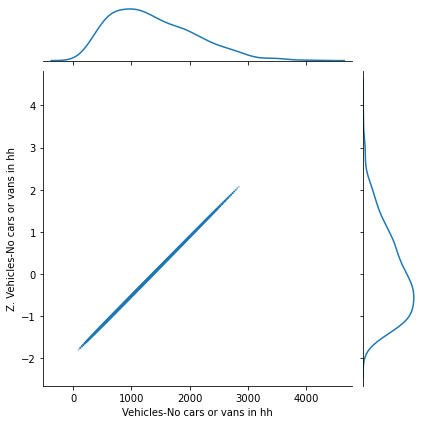

In [56]:
sns.jointplot(data=tr, x=f"{col}", y=f"Z. {col}", kind='kde'); # hex probably not the best choice

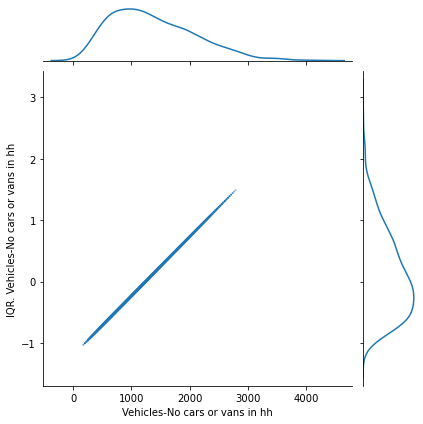

In [57]:
sns.jointplot(data=tr, x=f"{col}", y=f"IQR. {col}", kind='kde'); # hex probably not the best choice

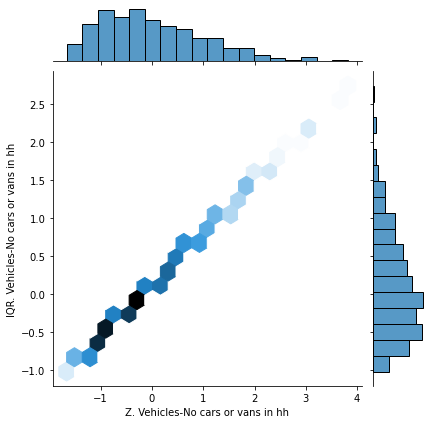

In [58]:
sns.jointplot(data=tr, x=f"Z. {col}", y=f"IQR. {col}", kind='hex'); # hex probably not the best choice

Perhaps a little more useful...

Text(0.5, 0, 'Standardised Value for No cars or vans in hh')

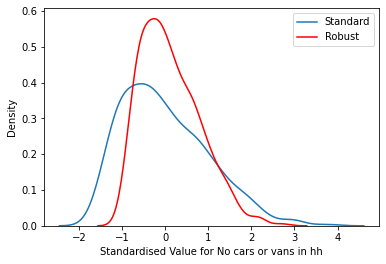

In [59]:
ax = sns.kdeplot(tr[f"Z. {col}"])
sns.kdeplot(tr[f"IQR. {col}"], color='r', ax=ax)
plt.legend(loc='upper right', labels=['Standard', 'Robust']) # title='Foo'
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Standardised Value for No cars or vans in hh")

#### 4.2.1 Questions?

- Can you see the differences between these two rescalers? 

> Again, on one level these haven't really changed much, if anything. But that's exactly what you *want* most of the time.

- Can you explain why you might want to choose one over the other?

> That said, when dealing with heavy skew (esp. long tails) you might find the Robust scaler more useful because the data remains *centered on zero*. This is a sharp constrast to the Standard Scalre which assumed that youre data is quasi-normally distributed. If you treat the skewed data using z-scores you'd be more likely to find that values are _statistically significant_ on either side. This problem also crops up in spatial statistics for quite similar reasons. 

## Task 5. Non-Linear Transformations

So transformations are useful when a data series has features that make comparisons or analysis difficult, or that affect our ability to intuit meaningful difference. By manipulating the data using one or more mathematical operations we can sometimes make it more *tractable* for subsequent analysis. In other words, it's all about the _context_ of our data.

[![How tall is tall?](http://img.youtube.com/vi/-VjcCr4uM6w/0.jpg)](http://www.youtube.com/watch?v=-VjcCr4uM6w)

From above, we know the _MedianIncome_ data are _not_ normally distributed, but can we work out what distribution best represents _MedianIncome_? This can be done by comparing the shape of the histogram to the shapes of theoretical distributitions. For example:

- the [log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution) distribution
- the [exponential](https://en.wikipedia.org/wiki/Exponential_distribution) distribution
- the [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution) distribution (for non-continuous data)
 
From looking at those theoretical distributions, we might make an initial guess as to the type of distribution. There are actually _many_ other distributions encountered in real life data, but these ones are particuarly common. A wider view of this would be that [quantile and power transformations](https://scikit-learn.org/stable/modules/preprocessing.html#non-linear-transformation) are ways of preserving the rank of values but lose many of the other features of the relationships that might be preserved by, for instance, the standard scaler.

In the case of Median Income, taking a log-transform of the data might make it _appear_ more normal: you do **not** say that a transformation _makes_ data more normal, you say either that 'it allows us to treat the data as normally distributed' or that 'the transformed data follows a log-normal distribution'.

### Task 5.1: The Normal Distribution

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

Z-scores are often associated with the normal distribution because their interpretation implicitly assumes a normal distribution. Or to put it another way... You can always calculate z-scores for your data (it's just a formula applied to data points), but their _intuitive meaning_ is lost if your data don't have something like a normal distribution (or follow the [68-95-99.7 rule](https://en.wikipedia.org/wiki/68–95–99.7_rule)).

But... what if our data are non-normal? Well, Just because data are non-normal doesn't mean z-scores can't be calculated (we already did that above); we just have to be careful what we do with them... and sometimes we should just avoid them entirely. 

#### 5.1.1 Creating a Normal Distribution

Below is a function to create that theoretical normal distribution. See if you can understand what's going and add comments to the code to explain what each line does. 

In [60]:
def normal_from_dist(series):  #define function name and required arguments (in this case a pandas series)
    mu = series.mean()         #calculate the mean of our data
    sd = series.std()          #calculate the standard deviation of our data
    n  = len(series)           #count how many observations are in our data
    s = np.random.normal(mu, sd, n)   #use the parameters of the data just calculated to generate n random numbers, drawn from a normal distributions 
    return s                   #return this set of random numbers

To make it easier to understand what the function above is doing, let's use it! We'll use the function to plot both a distribution plot with both histogram and KDE for our data, and then add a _second_ overplot distplot to the same fig showing the theoretical normal distribution (in red). We'll do this in a loop for each of the three variables we want to examine.

#### 5.1.2 Visual Comparisons

Looking at the output, which of the variables has a roughly normal distribution? Another way to think about this question is, for which of the variables are the mean and standard deviation _most_ appropriate as measures of centrality and spread?

*Also*, how would you determine the _meaning_ of some of the departures from the normal distribution?

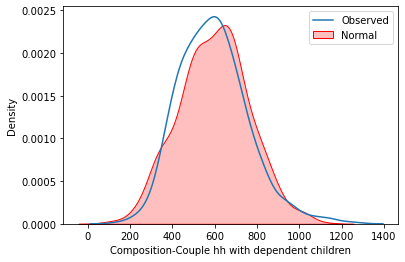

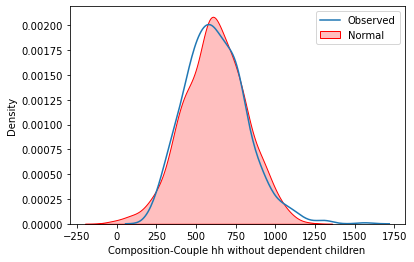

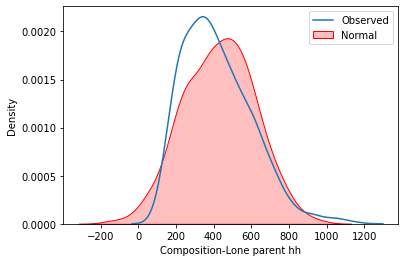

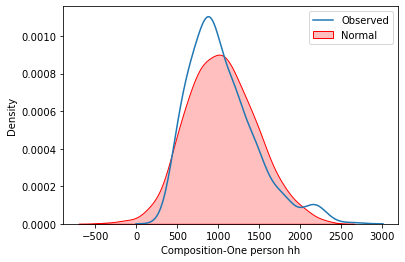

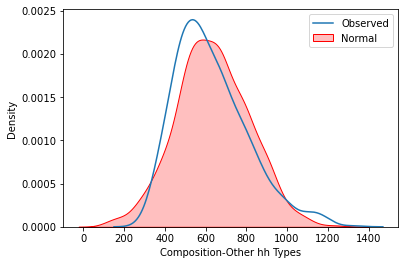

In [61]:
selection = [x for x in df_train.columns.values if x.startswith('Composition')]

for c in selection:
    ax = sns.kdeplot(df_train[c])
    sns.kdeplot(normal_from_dist(df_train[c]), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal']) # title='Foo'
    ax.ticklabel_format(useOffset=False, style='plain')
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    plt.show()

#### 5.1.3 Questions

- Which, if any, of the variables has a roughly normal distribution? Another way to think about this question is, for which of the variables are the mean and standard deviation _most_ appropriate as measures of centrality and spread?

> A couple of the distributions are quite close to normal when compared to other household compositions. Although these results haven't been area-standardised (i.e. by taking the LQ or share) there's certainly an interesting suggestion that there are some areas where there are a _lot_ of one person households!

- How might you determine the _significance_ of some of the departures from the normal distribution?

> I've largely answered this above: some particularly high values are quite interesting and would almost certainly warrant additional investigation if you were so minded. However, do keep in mind that we're looking at raw counts here and not the standardised values that would take into accout the size of the MSOA! I didn't want to add too much to each practical, but using the LQ or proportion/share here would be a very good idea.

### Task 5.2: Logarithmic Transformations

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

To create a new series in the data frame containing the natural log of the original value it’s a similar process to what we've done before, but since pandas doesn't provide a log-transform operator (i.e. you can’t call `df['MedianIncome'].log()` ) we need to use the `numpy` package since pandas data series are just numpy arrays with some fancy window dressing that makes them even _more_ useful:
```python
series = pd.Series(np.log(df.<series>))
```
Let's perform the transform then compare to the un-transformed data. Comment the code below to ensure that you understand what it is doing. 

#### 5.2.1 Apply and Plot

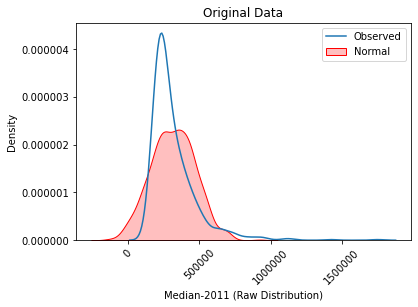

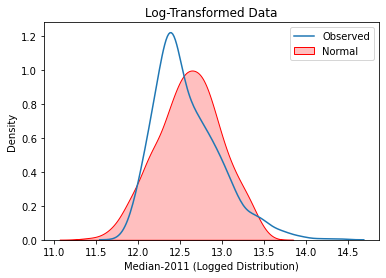

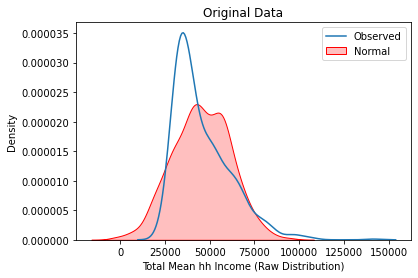

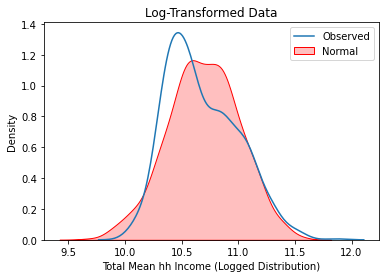

In [62]:
cols = ['Median-2011','Total Mean hh Income']

for m in cols:
    s  = df_train[m] # s == series
    ts = np.log(s)   # ts == transformed series
    
    ax = sns.kdeplot(s)
    sns.kdeplot(normal_from_dist(s), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal']) # title also an option
    plt.title("Original Data")
    
    ### USEFUL FORMATTING TRICKS ###
    # This turns off scientific notation in the ticklabels
    ax.ticklabel_format(useOffset=False, style='plain')
    # Notice this snippet of code
    ax.set_xlabel(ax.get_xlabel() + " (Raw Distribution)")
    # Notice this little code snippet too
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    
    plt.show()
    
    ax = sns.kdeplot(ts)
    sns.kdeplot(normal_from_dist(ts), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal'])
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel(ax.get_xlabel() + " (Logged Distribution)")
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    plt.title("Log-Transformed Data")
    plt.show()

Hopefully, you can see that the transformed data do indeed look 'more normal'; the peak of the red and blue lines are closer together and the blue line at the lower extreme is also closer to the red line, but we can check this by seeing what has happened to the z-scores.

### Task 5.3: Power Transformations 

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

Using lambda (transform 'exponent') of -0.87702


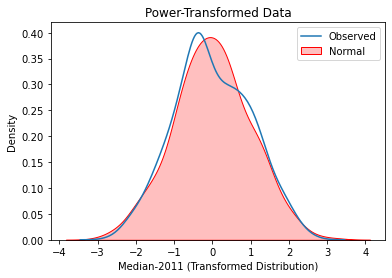

Using lambda (transform 'exponent') of -0.72212


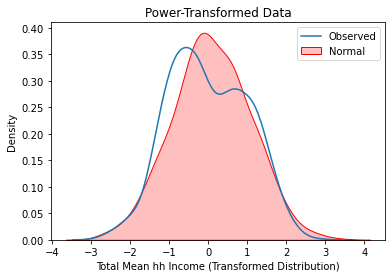

In [63]:
cols = ['Median-2011','Total Mean hh Income']
pt = PowerTransformer(method='yeo-johnson')

for m in cols:
    s  = df_train[m] # s == series
    ts = pt.fit_transform(s.values.reshape(-1,1))
    print(f"Using lambda (transform 'exponent') of {pt.lambdas_[0]:0.5f}")
    
    ax = sns.kdeplot(ts.reshape(-1,))
    
    sns.kdeplot(normal_from_dist(ts), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal'])
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel(m + " (Transformed Distribution)")
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    plt.title("Power-Transformed Data")
    plt.show();

## Task 6. Principal Components Analysis

Now we're going to ask the question: how can we represent our data using a smaller number of components that capture the variance in the original data.

### Optional Reload

Use this is your data gets messy...

In [64]:
gdf = gpd.read_feather(os.path.join('data','geo','MSOA_Atlas.geofeather')).set_index('MSOA Code')
print(gdf.shape)

(983, 85)


In [65]:
categoricals = ['Borough','Subregion']
for c in categoricals:
    gdf[c] = gdf[c].astype('category')

### Task 6.1: Calculating Shares

<div class="alert alert-block alert-danger">
    <b>Difficulty level</b>: Hard.
</div>

Sadly, there's no transformer to work this out for you automatically, but let's start by converting the raw population and household figures to shares so that our later dimensionality reduction steps aren't impacted by the size of the MSOA.

In [66]:
gdf[['Age-All Ages','Households-All Households']].head(5)

,Age-All Ages,Households-All Households
MSOA Code,,
E02000001,7375.0,4385.0
E02000002,6775.0,2713.0
E02000003,10045.0,3834.0
E02000004,6182.0,2318.0
E02000005,8562.0,3183.0


#### 6.1.1 Specify Totals Columns

In [67]:
total_pop = gdf['Age-All Ages']
total_hh  = gdf['Households-All Households']
total_vec = gdf['Vehicles-Sum of all cars or vans in the area']

#### 6.1.2 Specify Columns for Pop or HH Normalisation

In [68]:
pop_cols  = ['Age-', 'Composition-', 'Qualifications-', 'Economic Activity-', 'White', 'Mixed/multiple',
             'Asian/Asian British', 'Black/African', 'BAME', 'Other ethnic',
             'Country of Birth-']
hh_cols   = ['Language-', 'Tenure-', 'Households-', 'Detached', 'Semi-detached', 'Terraced', 'Flat, ']

In [69]:
popre = re.compile(r'^(?:' + "|".join(pop_cols) + r')')
hhre  = re.compile(r'^(?:' + "|".join(hh_cols) + r')')

#### 6.1.3 Apply to Columns

In [70]:
tr_gdf = gdf.copy()
tr_gdf['Mean hh size'] = tr_gdf['Age-All Ages']/tr_gdf['Households-All Households']

for c in gdf.columns:
    print(c)
    if popre.match(c):
        print("  Normalising by total population.")
        tr_gdf[c] = gdf[c]/total_pop
    elif hhre.match(c):
        print("  Normalising by total households.")
        tr_gdf[c] = gdf[c]/total_hh
    elif c.startswith('Vehicles-') and not c.startswith('Vehicles-Cars per hh'):
        print("  Normalising by total vehicles.")
        tr_gdf[c] = gdf[c]/total_vec
    else:
        print("  Passing through.")

MSOA11NMW
  Passing through.
BNG_E
  Passing through.
BNG_N
  Passing through.
LONG
  Passing through.
LAT
  Passing through.
Shape__Are
  Passing through.
Shape__Len
  Passing through.
geometry
  Passing through.
MSOA Name
  Passing through.
Age-All Ages
  Normalising by total population.
Age-0-15
  Normalising by total population.
Age-16-29
  Normalising by total population.
Age-30-44
  Normalising by total population.
Age-45-64
  Normalising by total population.
Age-65+
  Normalising by total population.
Age-Working-age
  Normalising by total population.
Households-All Households
  Normalising by total households.
Composition-Couple hh with dependent children
  Normalising by total population.
Composition-Couple hh without dependent children
  Normalising by total population.
Composition-Lone parent hh
  Normalising by total population.
Composition-One person hh
  Normalising by total population.
Composition-Other hh Types
  Normalising by total population.
White
  Normalising by to

### Task 6.2: Removing Columns

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

To perform dimensionality we can only have numeric data. In theory, categorical data can be converted to numeric and retained, but there are two issues:

1. Nominal data has no _innate_ order so we _can't_ convert > 2 categories to numbers and have to convert them to One-Hot Encoded values.
2. A binary (i.e. One-Hot Encoded) variable will account for a _lot_ of variance in the data because it's only two values they are 0 and 1!

So in practice, it's probably a good idea to drop categorical data if you're planning to use PCA.

#### 6.2.1 Drop Totals Columns

In [71]:
pcadf = tr_gdf.drop(columns=['Age-All Ages', 'Households-All Households',
                             'Vehicles-Sum of all cars or vans in the area'])

#### 6.2.2 Drop Non-Numeric Columns

In [72]:
pcadf.select_dtypes(['category','object']).columns

Index(['MSOA11NMW', 'MSOA Name', 'Borough', 'Subregion'], dtype='object')

In [73]:
pcadf.drop(columns=pcadf.select_dtypes(['category','object']).columns.to_list(), inplace=True)
pcadf.drop(columns=['BNG_E','BNG_N','geometry', 'LONG', 'LAT','Shape__Are', 'Shape__Len'], inplace=True)

In [74]:
pcadf.columns

Index(['Age-0-15', 'Age-16-29', 'Age-30-44', 'Age-45-64', 'Age-65+',
       'Age-Working-age', 'Composition-Couple hh with dependent children',
       'Composition-Couple hh without dependent children',
       'Composition-Lone parent hh', 'Composition-One person hh',
       'Composition-Other hh Types', 'White', 'Mixed/multiple ethnic groups',
       'Asian/Asian British', 'Black/African/Caribbean/Black British',
       'Other ethnic group', 'BAME', 'Country of Birth-United Kingdom',
       'Country of Birth-Not United Kingdom',
       'Language-1+ English as a main language',
       'Language-None have English as main language', 'Tenure-Owned outright',
       'Tenure-Owned with a mortgage or loan', 'Tenure-Social rented',
       'Tenure-Private rented',
       'Household spaces with at least one usual resident',
       'Household spaces with no usual residents', 'Detached', 'Semi-detached',
       'Terraced (including end-terrace)', 'Flat, maisonette or apartment',
       'Populatio

### Task 6.3: Rescale & Reduce

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

In order to ensure that our results aren't dominated by a single scale (e.g. House Prices!) we need to rescale all of our data. You could easily try different scalers as well as a different parameters to see what effect this has on your results.

#### 6.3.1 Robustly Rescale

Set up the Robust Rescaler for inter-decile standardisation: 10th and 90th quantiles.

In [75]:
rs = RobustScaler(quantile_range=(10.0, 90.0))

for c in pcadf.columns.values:
    pcadf[c] = rs.fit_transform(pcadf[c].values.reshape(-1, 1))

#### 6.3.2 PCA Reduce

In [76]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=50, whiten=True) 

pca.fit(pcadf)

explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_

#### 6.3.3 Examine Explained Variance

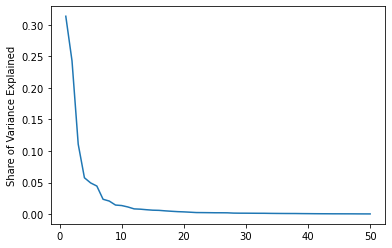

In [77]:
x = np.arange(1,len(explained_variance)+1)
plt.plot(x, explained_variance)
plt.ylabel('Share of Variance Explained')
plt.show()

In [78]:
for i in range(0, 20):
    print(f"Component {i:>2} accounts for {explained_variance[i]*100:>2.2f}% of variance")

Component  0 accounts for 31.35% of variance
Component  1 accounts for 24.29% of variance
Component  2 accounts for 11.09% of variance
Component  3 accounts for 5.77% of variance
Component  4 accounts for 4.95% of variance
Component  5 accounts for 4.46% of variance
Component  6 accounts for 2.36% of variance
Component  7 accounts for 2.08% of variance
Component  8 accounts for 1.45% of variance
Component  9 accounts for 1.37% of variance
Component 10 accounts for 1.14% of variance
Component 11 accounts for 0.84% of variance
Component 12 accounts for 0.80% of variance
Component 13 accounts for 0.71% of variance
Component 14 accounts for 0.64% of variance
Component 15 accounts for 0.61% of variance
Component 16 accounts for 0.53% of variance
Component 17 accounts for 0.47% of variance
Component 18 accounts for 0.41% of variance
Component 19 accounts for 0.37% of variance


You should get that Component 0 accounts for 31.35% of the variance and Component 19 accounts for 0.37%.

#### 6.3.4: How Many Components?

There are a number of ways that we could set a threshold for dimensionality reduction: 
- The most common is to look for the 'knee' in the Explained Variance plot above. That would put us at about 5 retained components.
- Another is to just keep all components contributing more than 1% of the variance. That would put us at about 10 components.
- You can also ([I discovered](https://medium.com/@nikolay.oskolkov/hi-jon-reades-my-sincere-apologies-for-this-very-late-reply-444f57054d14)) look to shuffle the data and repeatedly perform PCA to build confidence intervals. I have not implemented this (yet).

In order to _do_ anything with these components we need to somehow reattach them to the MSOAs. So that entails taking the transformed results (`X_train` and `X_test`) 

Knee detected at: 7


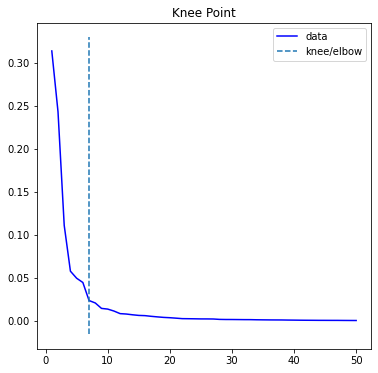

In [79]:
kn = knee_locator.KneeLocator(x, explained_variance, 
                              curve='convex', direction='decreasing', 
                              interp_method='interp1d')
print(f"Knee detected at: {kn.knee}")
kn.plot_knee()

In [80]:
keep_n_components = 7

# If we weren't changing the number of components we
# could re-use the pca object created above. 
pca = PCA(n_components=keep_n_components, whiten=True)

X_train = pca.fit_transform(pcadf)

# Notice that we get the _same_ values out,
# so this is a *deterministic* process that
# is fully replicable (allowing for algorithmic
# and programming language differences).
print(f"Total explained variance: {pca.explained_variance_ratio_.sum()*100:2.2f}%")
for i in range(0, keep_n_components):
    print(f"  Component {i:>2} accounts for {pca.explained_variance_ratio_[i]*100:>5.2f}% of variance")

# Notice...
print(f"X-train shape: {len(X_train)}")
print(f"PCA df shape: {pcadf.shape[0]}")
# So each observation has a row in X_train and there is 
# 1 column for each component. This defines the mapping
# of the original data space into the reduced one
print(f"Row 0 of X-train contains {len(X_train[0])} elements.") 

Total explained variance: 84.27%
  Component  0 accounts for 31.35% of variance
  Component  1 accounts for 24.29% of variance
  Component  2 accounts for 11.09% of variance
  Component  3 accounts for  5.77% of variance
  Component  4 accounts for  4.95% of variance
  Component  5 accounts for  4.46% of variance
  Component  6 accounts for  2.36% of variance
X-train shape: 983
PCA df shape: 983
Row 0 of X-train contains 7 elements.


### Task 6.4: Components to Columns

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

You could actually do this more quickly (but less clearly) using `X_train.T` to transpose the matrix!

In [81]:
for i in range(0,keep_n_components):
    s = pd.Series(X_train[:,i], index=pcadf.index)
    pcadf[f"Component {i+1}"] = s

In [82]:
pcadf.sample(3).iloc[:,-10:-4]

,Vehicles-4 or more cars or vans in hh,Vehicles-Cars per hh,Mean hh size,Component 1,Component 2,Component 3
MSOA Code,,,,,,
E02000627,-0.283230,-0.475571,-0.163844,0.102488,-1.268605,-0.787546
E02000871,-0.275683,-0.452733,0.320913,-0.819394,-1.300594,0.149914
E02000909,-0.211679,-0.051141,-0.005239,-0.052609,-0.016698,-0.579238


### Task 6.7: (Re)Attaching GeoData

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

In [83]:
msoas = gpd.read_file(os.path.join('data','geo','Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip'), driver='ESRI Shapefile')
print(msoas.columns)

Index(['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'MSOA11NMW', 'BNG_E', 'BNG_N',
       'LONG', 'LAT', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')


In [84]:
gpcadf = pd.merge(msoas.set_index(['MSOA11CD'], drop=True), pcadf, left_index=True, right_index=True, how='inner')
print(f"Geo-PCA df has shape {gpcadf.shape[0]} x {gpcadf.shape[1]}")

Geo-PCA df has shape 983 x 89


You should get `PCA df has shape 983 x 89`.

In [85]:
gpcadf['Borough'] = gpcadf.MSOA11NM.apply(lambda x: x[:-4])

### Task 6.8: Map the First _n_ Components

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

How would you automate this so that the loop creates one plot for each of the first 4 components?

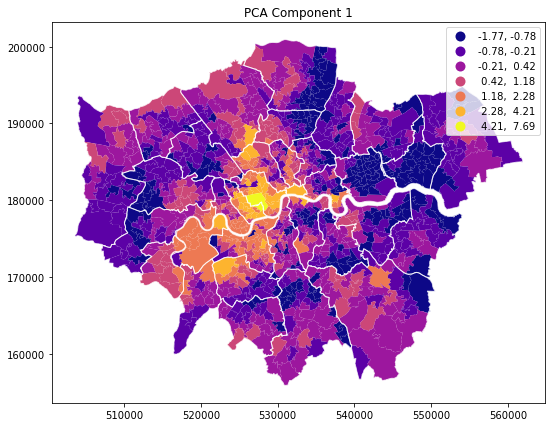

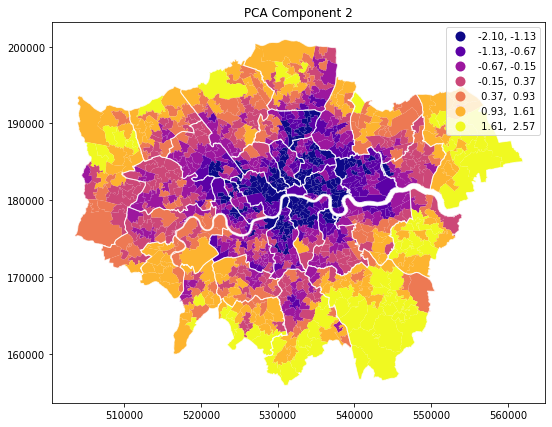

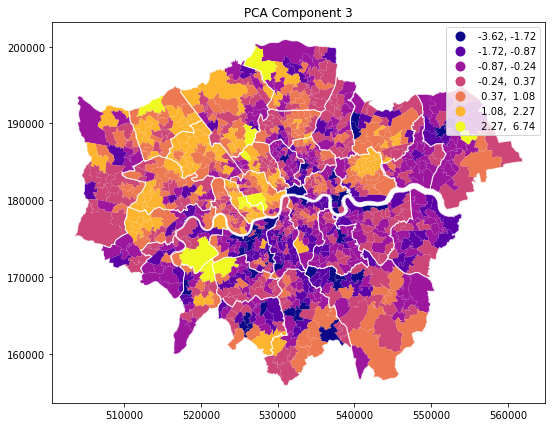

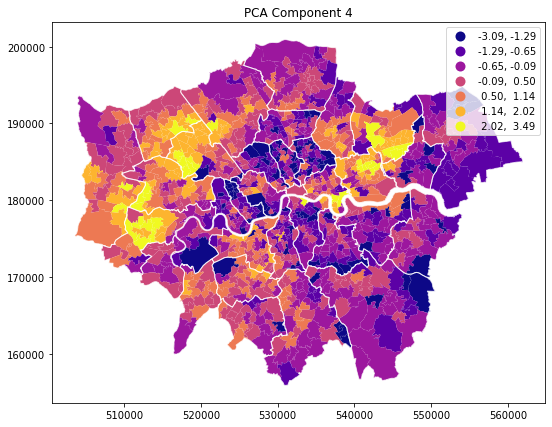

In [16]:
for comp in [f"Component {x}" for x in range(1,5)]:
    ax = gpcadf.plot(column=comp, cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));
    boros.plot(ax=ax, edgecolor='w', facecolor='none', linewidth=1, alpha=0.7)
    ax.set_title(f'PCA {comp}')

Your first component map should look something like this:
    
![PCA Component 1](https://github.com/jreades/fsds/raw/master/practicals/img/PCA-Component-1.png)

## Task 7. UMAP

### Task 7.1: UMAP on Raw Data

<div class="alert alert-block alert-danger">
    <b>Difficulty level</b>: Hard.
</div>

In [87]:
from umap import UMAP

# You might want to experiment with all
# 3 of these values -- it may make sense 
# to package a lot of this up into a function!
keep_dims=2
rs=42

u = UMAP(
    n_neighbors=25,
    min_dist=0.01,
    n_components=keep_dims,
    random_state=rs)

X_embedded = u.fit_transform(pcadf)
print(X_embedded.shape)

(983, 2)


### Task 7.2: Write to Data Frame

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

Can probably also be solved using `X_embedded.T`.

In [88]:
for ix in range(0,X_embedded.shape[1]):
    print(ix)
    s = pd.Series(X_embedded[:,ix], index=pcadf.index)
    gpcadf[f"Dimension {ix+1}"] = s

0
1


### Task 7.3: Visualise!

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

In [89]:
rddf = gpcadf.copy()  # Reduced Dimension Data Frame

#### 7.3.1 Simple Scatter

<AxesSubplot:xlabel='Dimension 1', ylabel='Dimension 2'>

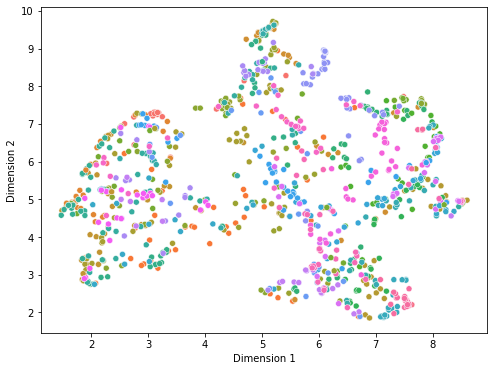

In [90]:
f,ax = plt.subplots(1,1,figsize=(8,6))
sns.scatterplot(x=rddf['Dimension 1'], y=rddf['Dimension 2'], hue=rddf['Borough'], legend=False, ax=ax)

#### 7.3.2 Seaborn Jointplot

That is *suggestive* of there being struccture in the data, but with 983 data points and 33 colours it's hard to make sense of what the structure *might* imply. Let's try this again using the Subregion instead and taking advantage of the Seaborn visualisation library's `jointplot` (joint distribution plot):

In [91]:
rddf['Subregion'] = rddf.Borough.apply(lambda x: mapping[x])

In [9]:
# Sets some handy 'keywords' to tweak the Seaborn plot
kwds = dict(s=7,alpha=0.95,edgecolor="none")
# Set the *hue order* so that all plots have some colouring by Subregion
ho = ['Inner East','Inner West','Outer West and North West','Outer South','Outer East and North East']

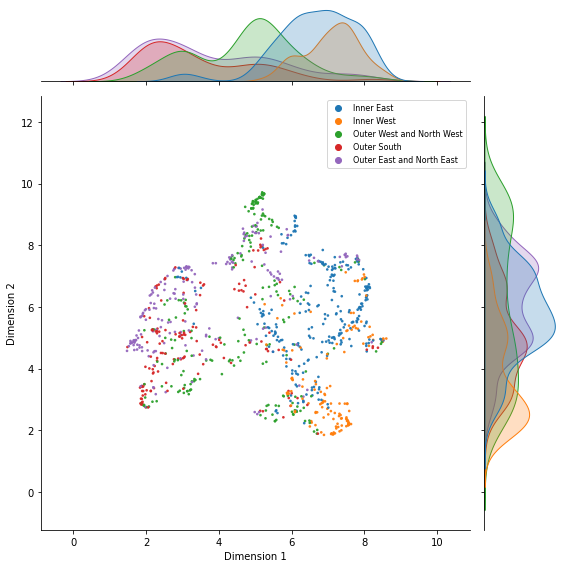

In [10]:
g = sns.jointplot(data=rddf, x='Dimension 1', y='Dimension 2', height=8, 
                  hue='Subregion', hue_order=ho, joint_kws=kwds)
g.ax_joint.legend(loc='upper right', prop={'size': 8});

Your first dimension map should look something like this:

![UMAP Jointplot](https://github.com/jreades/fsds/raw/master/practicals/img/UMAP-Dimension-1.png)

What do you make of this?

Maybe let's give this one last go splitting the plot out by subregion so that we can see how these vary:

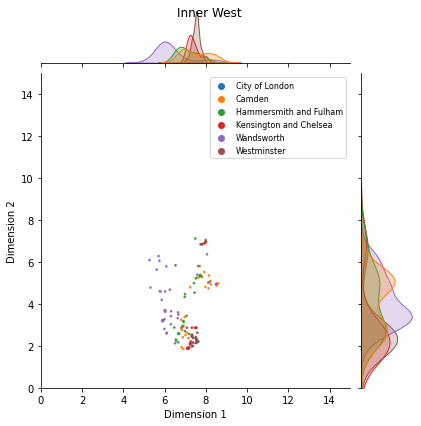

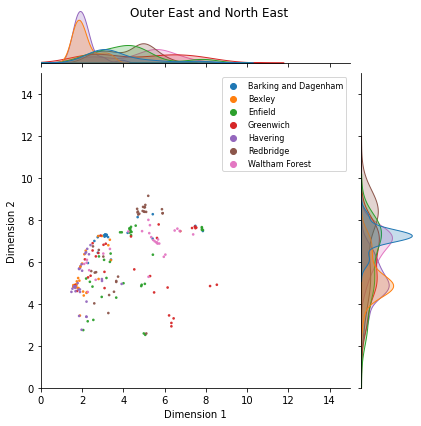

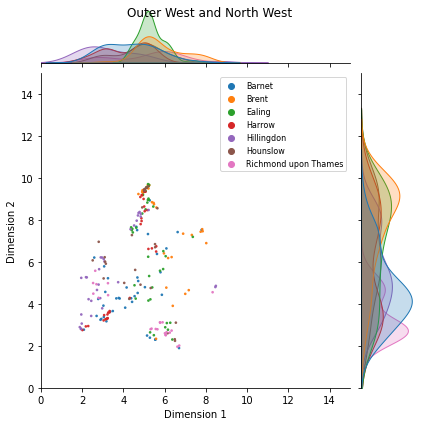

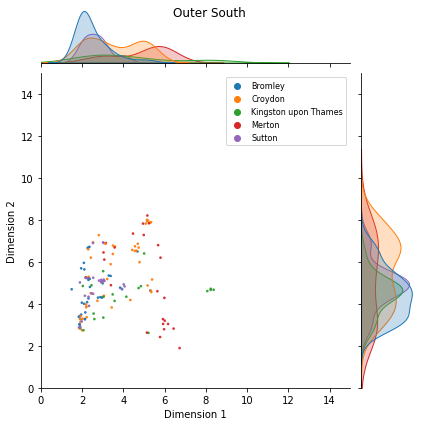

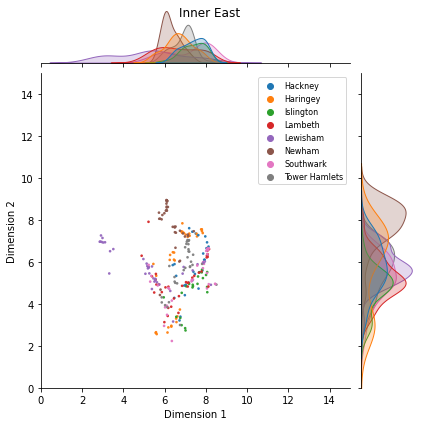

In [94]:
for r in rddf.Subregion.unique():
    g = sns.jointplot(data=rddf[rddf.Subregion==r], x='Dimension 1', y='Dimension 2', 
                  hue='Borough', joint_kws=kwds)
    g.ax_joint.legend(loc='upper right', prop={'size': 8});
    g.ax_joint.set_ylim(0,15)
    g.ax_joint.set_xlim(0,15)
    plt.suptitle(r)

We can't unfortunately do any clustering at this point to create groups from the data (that's next week!) so for now note that there are several large-ish groups (in terms of membership) and few small ones picked up by t-SNE. Alos note that there is strong evidence of some incipient structure: Inner East and West largely clump together, while Outher East and Outer South also seem to group together, with Outer West being more distinctive. If you look back at the PCA Components (especially \#1) you might be able to speculate about some reasons for this! Please note: this is _only_ speculation at this time!

Next week we'll also add the listings data back in as part of the picture!

### Task 7.4: Map the _n_ Dimensions

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

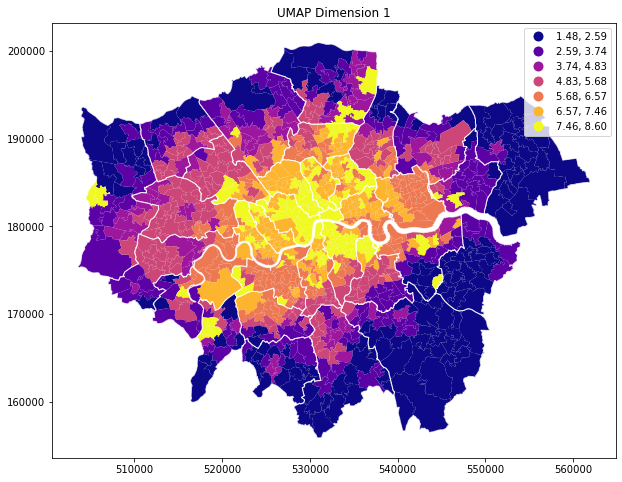

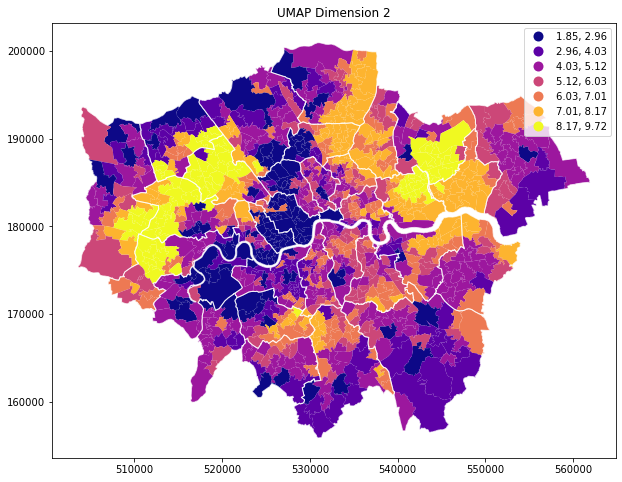

In [14]:
for comp in [f"Dimension {x}" for x in range(1,3)]:
    f, ax = plt.subplots(1,1,figsize=(12,8))
    rddf.plot(column=comp, cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, ax=ax);
    boros.plot(edgecolor='w', facecolor='none', linewidth=1, alpha=0.7, ax=ax)
    ax.set_title(f'UMAP {comp}')

Your first dimension map should look something like this:

![UMAP Dimension 1](https://github.com/jreades/fsds/raw/master/practicals/img/UMAP-Dimension-1.png)

### Task 7.5: And Save

In [96]:
rddf.to_feather(os.path.join('data','clean','Reduced_Dimension_Data.geofeather'))

#### 7.5.1 Questions

- How would you compare/contrast PCA components with UMAP dimensions? Why do they not seem to show the same thing even though *both* seem to show *something*?

> UMAP is forcing the entire structure of the data into 2 dimensions and is a non-linear transformation, so there is no loss of variance as there is with PCA. The first PCA components shows the axis of maximum variance in the data and, I'd suggest, probably lines up with the big differences in house prices and income, whereas the first dimension of the UMAP output seems to capture more in the way of structure (i.e. that Inner London is different in fundamental ways from Outer London).

- What might you do with the output of either the PCA or UMAP processes?

> Cluster them! That's next week.

## Credits!

#### Contributors:
The following individuals have contributed to these teaching materials: Jon Reades (j.reades@ucl.ac.uk).

#### License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).

#### Potential Dependencies:
This notebook may depend on the following libraries: pandas, geopandas, sklearn, matplotlib, seaborn